In [1]:
import os
import re
import pandas as pd
import scanpy as sc

# Define the folder path
data_folder = "agent/data_file"

# Initialize lists to store expression data and metadata
all_expression_data = []
all_metadata = []

# Pattern to match filenames
file_pattern = re.compile(r'.*_cell-gene_UMI_table\.tsv$')

# Iterate through all files in the folder
for filename in os.listdir(data_folder):
    if file_pattern.match(filename):
        # Extract metadata from filename
        sample_id = filename.split('_')[1]  # Extract second element in the filename
        marker_type = sample_id[0]  # Extract first character of sample_id
        
        # Load the expression data into a Pandas DataFrame
        file_path = os.path.join(data_folder, filename)
        expression_data = pd.read_csv(file_path, sep='\t', index_col=0)
        
        # Extract cell IDs for metadata
        metadata = pd.DataFrame(index=expression_data.index)
        metadata['cell_id'] = expression_data.index
        metadata['sample_id'] = sample_id
        metadata['marker_type'] = marker_type
        
        # Store the data
        all_expression_data.append(expression_data)
        all_metadata.append(metadata)

# Concatenate all expression data and metadata into single DataFrames
expression_data_combined = pd.concat(all_expression_data, axis=0)
metadata_combined = pd.concat(all_metadata, axis=0)
metadata_combined.set_index('cell_id', inplace=True)

# Create the AnnData object
adata = sc.AnnData(X=expression_data_combined.values)
adata.obs = metadata_combined
adata.var = pd.DataFrame(index=expression_data_combined.columns)
adata.var.rename_axis("gene_name", inplace=True)

# Ensure unique gene names
adata.var_names_make_unique()

# Verify the final AnnData object
print(adata)

AnnData object with n_obs × n_vars = 84129 × 10105
    obs: 'sample_id', 'marker_type'


In [2]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import issparse

# Step 1: Compute QC Metrics

# Identify mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT.")

# Compute QC metrics and ensure they're stored in adata.obs
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

# Step 2: Filter Low-Quality Cells

# Apply filtering criteria for cells with explicit copy
adata = adata[
    (adata.obs["n_genes_by_counts"] > 400) &
    (adata.obs["pct_counts_mt"] > 0.5) &
    (adata.obs["pct_counts_mt"] <= 10)
].copy()

# Step 3: Efficient Handling of Sparse Matrices

# Check sparsity and convert to dense only if sparse
if issparse(adata.X):
    adata.X = adata.X.toarray()

# Step 4: Normalize & Log Transform

# Normalize total UMI counts per cell
sc.pp.normalize_total(adata, target_sum=1e6)

# Logarithmic transformation
sc.pp.log1p(adata)

# Step 5: Select and Subset Highly Variable Genes

# Ensure there are genes for processing
if adata.shape[1] > 0:
    # Identify highly variable genes
    sc.pp.highly_variable_genes(adata, n_top_genes=4000)
    
    # Subset the dataset to highly variable genes with explicit copy
    adata = adata[:, adata.var["highly_variable"]].copy()

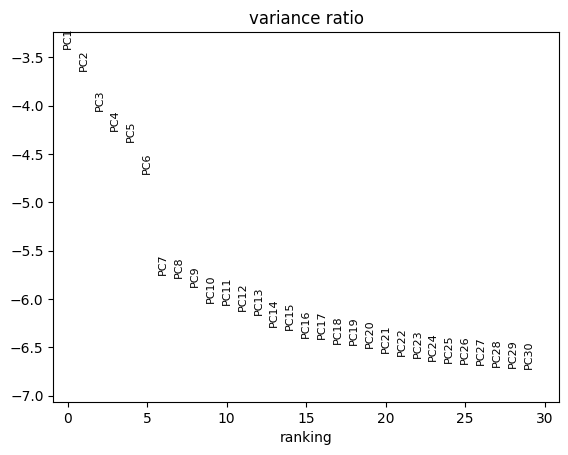

/Users/silviachen/Documents/Software/SCAagent/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/var/folders/zg/0k9dpp614nxbvdbh46x_9d_h0000gn/T/ipykernel_1841/575386829.py:18: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=2.0)


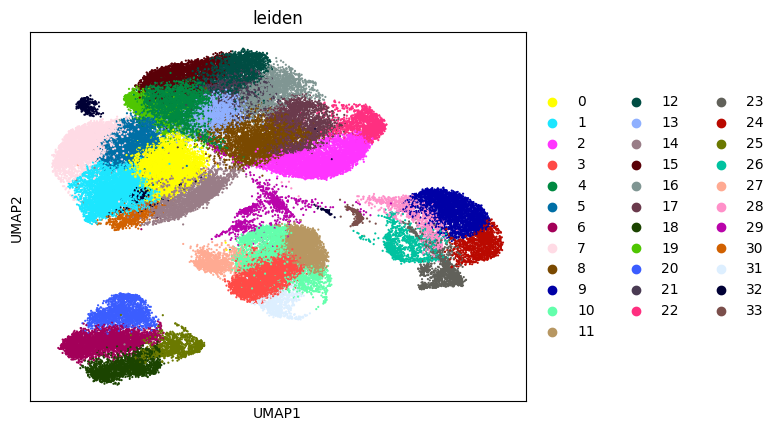

In [3]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Run PCA
n_pcs = 30  # Choose a biologically reasonable number of PCs (e.g., 30 typically captures meaningful structure in scRNA-seq data)
sc.tl.pca(adata, n_comps=n_pcs)

# Plot explained variance ratio to confirm the selection of PCs
sc.pl.pca_variance_ratio(adata, log=True)

# Construct the neighborhood graph
n_neighbors = 15  # Choosing a reasonable default for the number of neighbors
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs)

# Perform clustering with Leiden algorithm at resolution 2.0
sc.tl.leiden(adata, resolution=2.0)

# Run UMAP for dimensionality reduction
sc.tl.umap(adata)

# Visualize the clustering results colored by Leiden clusters
sc.pl.umap(adata, color='leiden', size=10)

/Users/silviachen/Documents/Software/SCAagent/.venv/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:429: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/Users/silviachen/Documents/Software/SCAagent/.venv/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:431: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/Users/silviachen/Documents/Software/SCAagent/.venv/lib/python3.13/site-packa

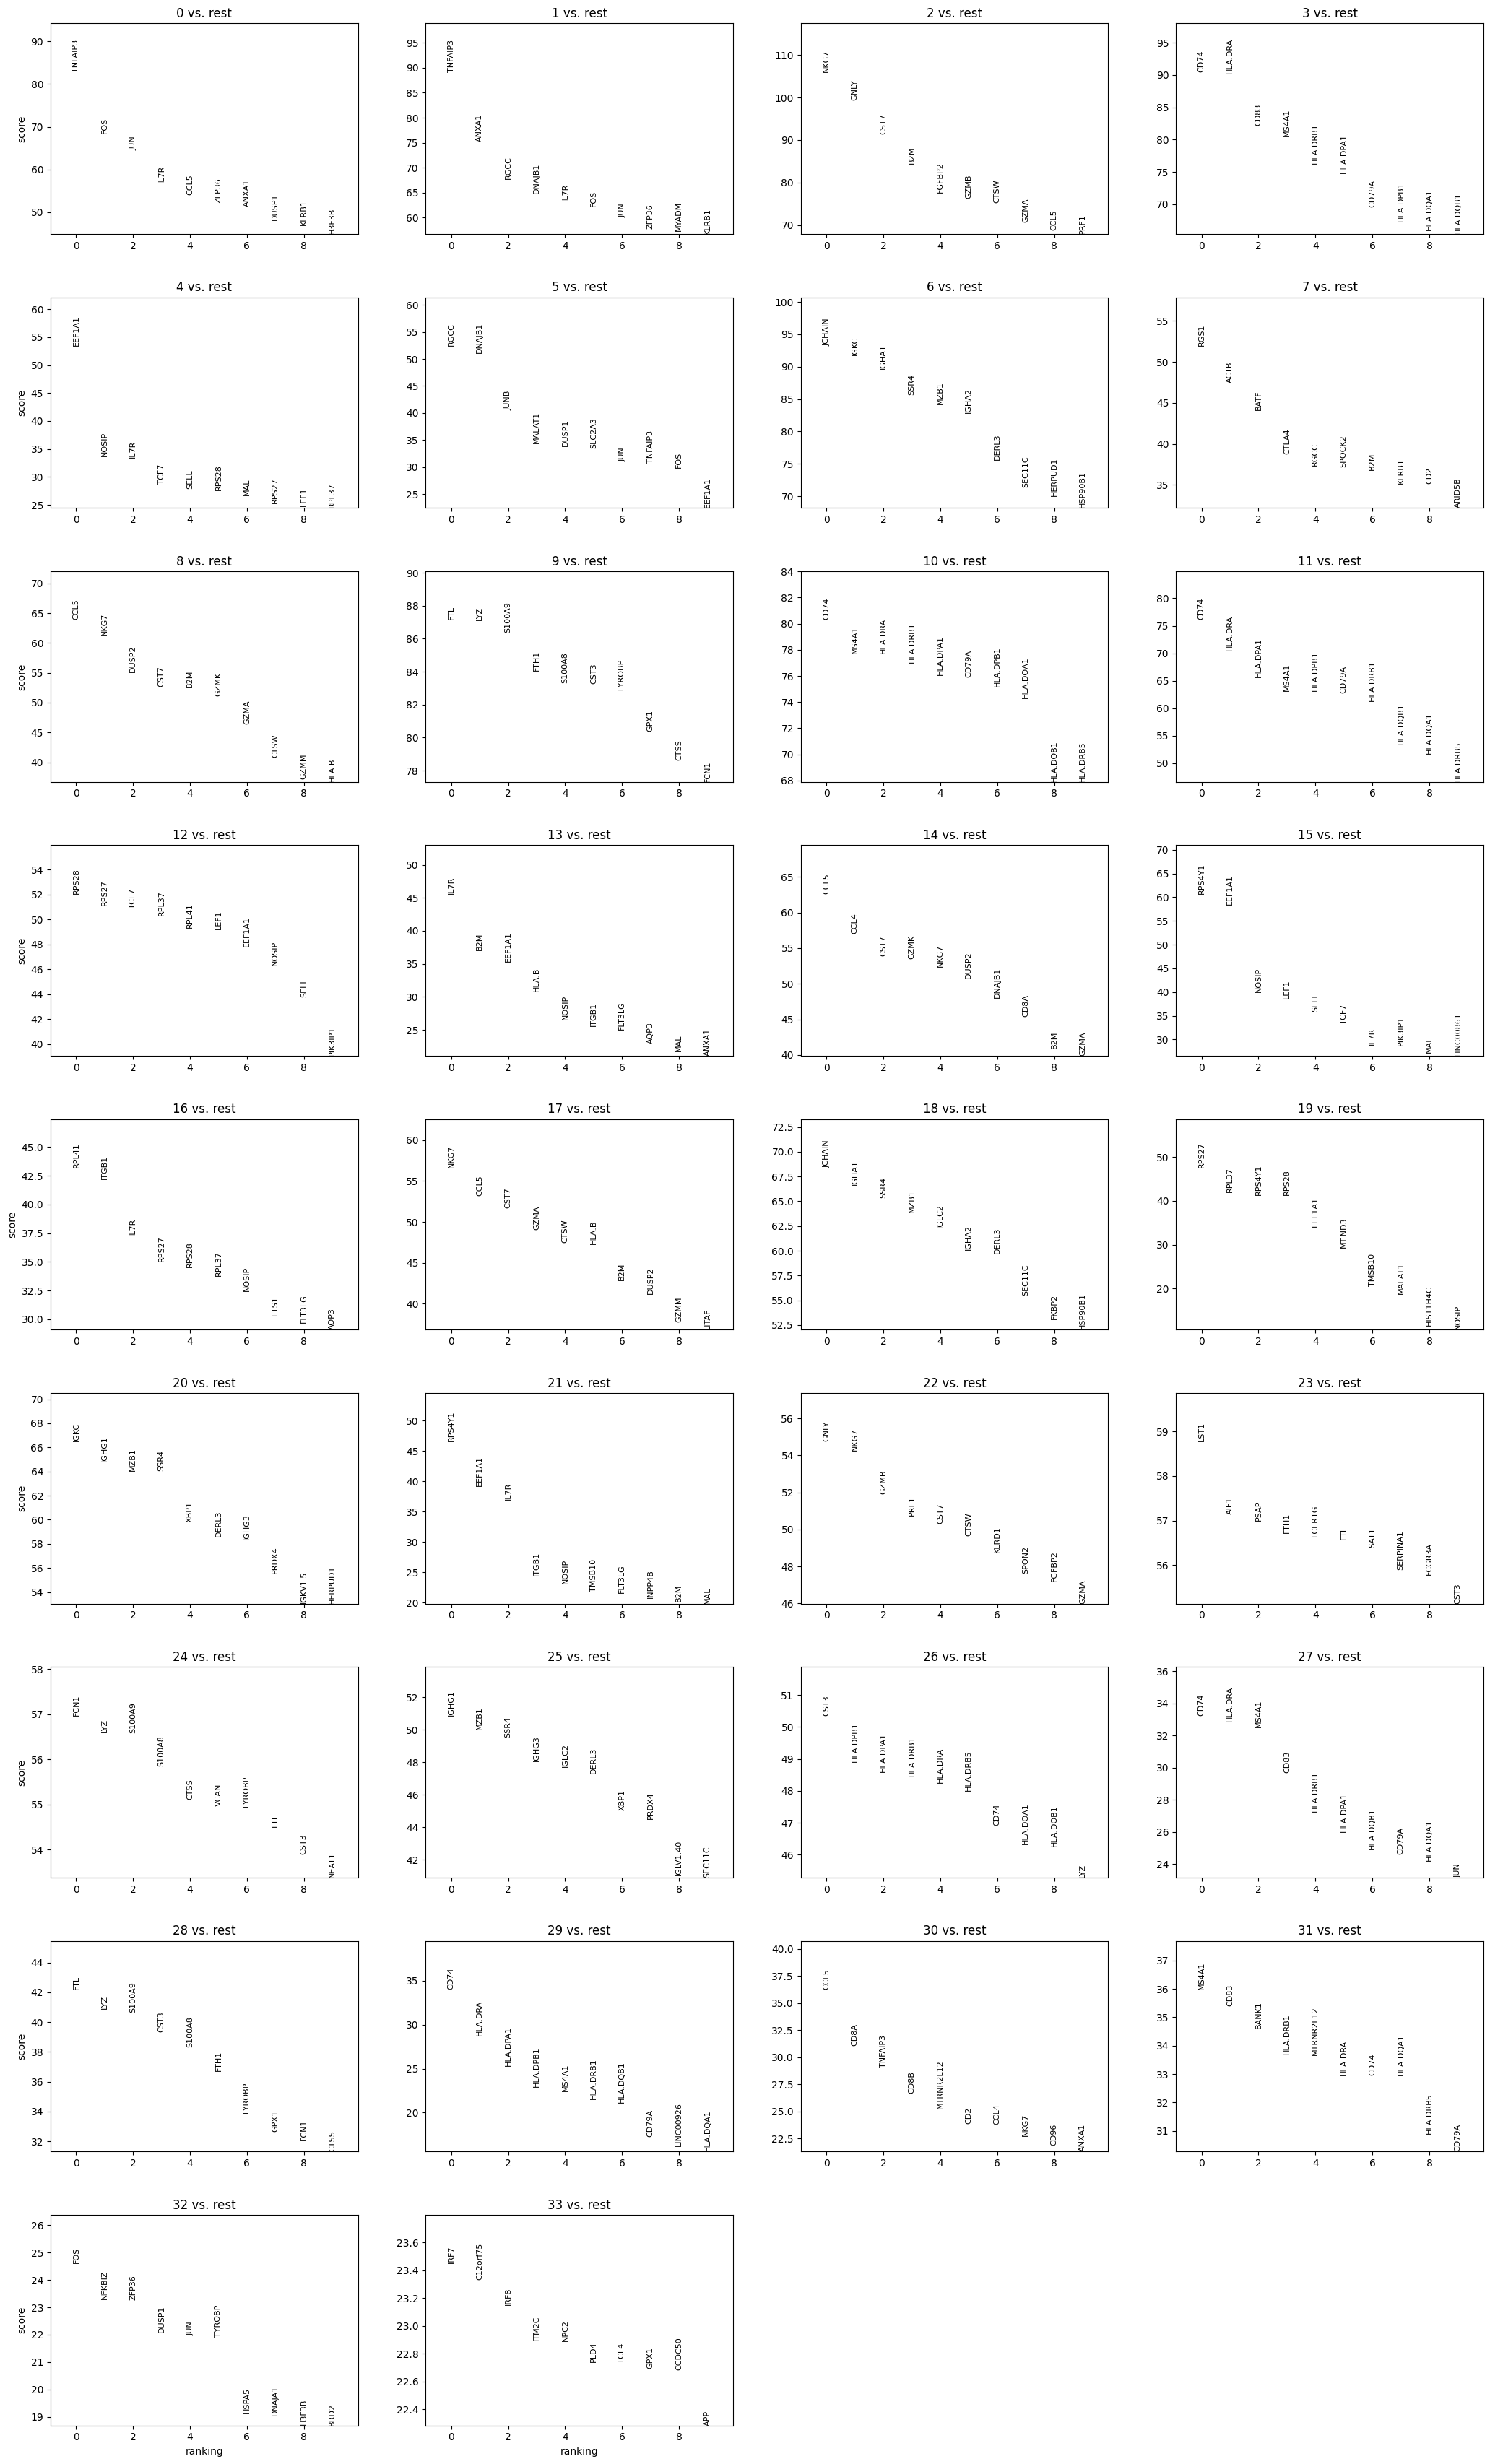

Counts of cells per cluster or cell type (if annotated):
leiden
0     5256
1     4624
2     4449
3     4197
4     4137
5     3262
6     3215
7     3114
8     3083
9     2850
10    2799
11    2414
12    2366
13    2345
14    2324
15    2313
16    1892
17    1872
18    1774
19    1721
20    1638
21    1627
22    1235
23    1221
24    1190
25     995
26     898
27     875
28     861
29     855
30     646
31     611
32     538
33     220
Name: count, dtype: int64
Validated marker genes:
{'T_cells': ['IL7R'], 'B_cells': ['CD79A', 'CD79B', 'MS4A1'], 'NK_cells': ['NCAM1', 'KLRD1', 'NKG7', 'GNLY'], 'Myeloid_cells': ['LYZ', 'CD68', 'FCGR3A', 'VCAN']}
Cluster annotations based on marker gene expression:
{'0': 'T_cells', '1': 'T_cells', '2': 'NK_cells', '3': 'B_cells', '4': 'T_cells', '5': 'T_cells', '6': 'B_cells', '7': 'T_cells', '8': 'T_cells', '9': 'Myeloid_cells', '10': 'B_cells', '11': 'B_cells', '12': 'T_cells', '13': 'T_cells', '14': 'NK_cells', '15': 'T_cells', '16': 'T_cells', '17': 'NK

In [4]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Identify Marker Genes for Each Cluster
# Perform differential expression analysis for each Leiden cluster
sc.tl.rank_genes_groups(adata, groupby="leiden", method="wilcoxon")

# Visualize the top 10 differentially expressed genes per cluster
sc.pl.rank_genes_groups(adata, n_genes=10, sharey=False)

# 2. Count Cells per Cell Type
# Assuming 'cell_type' is the column that will store eventual cluster annotations
if "cell_type" in adata.obs:  # If 'cell_type' exists, count distributions
    counts = adata.obs["cell_type"].value_counts()
else:  # If not yet annotated
    counts = adata.obs["leiden"].value_counts()

# Print counts for verification
print(f"Counts of cells per cluster or cell type (if annotated):\n{counts}")

# 3. Define Marker Gene Sets for Cell Type Annotation
# Create a dictionary of marker genes for known immune cell types
marker_genes = {
    "T_cells": ["CD3D", "CD3E", "CD3G", "IL7R"],
    "B_cells": ["CD79A", "CD79B", "MS4A1"],
    "NK_cells": ["NCAM1", "KLRD1", "NKG7", "GNLY"],
    "Myeloid_cells": ["LYZ", "CD68", "FCGR3A", "VCAN"]
}

# Verify that marker genes match those in the dataset
# Retain only markers present in adata.var_names
for cell_type, genes in marker_genes.items():
    marker_genes[cell_type] = [gene for gene in genes if gene in adata.var_names]

print(f"Validated marker genes:\n{marker_genes}")

# 4. Assign Cell Types to Clusters
# Initialize a dictionary to store cluster-to-cell type mappings
cluster_annotations = {}

# Iterate over unique Leiden clusters
for cluster in adata.obs["leiden"].cat.categories:  # Cluster IDs are categorical
    cluster_cells = adata[adata.obs["leiden"] == cluster]  # Subset cells in the cluster
    mean_expression = {}
    
    # Compute average expression of marker genes for each cell type
    for cell_type, genes in marker_genes.items():
        if len(genes) > 0:  # Ensure there are valid marker genes
            mean_expression[cell_type] = cluster_cells[:, genes].X.mean()
        else:
            mean_expression[cell_type] = -np.inf  # Assign -inf to handle empty marker sets
    
    # Assign the cell type with the highest average marker expression
    best_match = max(mean_expression, key=mean_expression.get)
    cluster_annotations[cluster] = best_match

print(f"Cluster annotations based on marker gene expression:\n{cluster_annotations}")

# 5. Store Cluster Annotations
# Map Leiden cluster IDs to inferred cell types in a new `cell_type` column
adata.obs["cell_type"] = adata.obs["leiden"].map(cluster_annotations)

# Inspect the resulting "cell_type" column
print(adata.obs[["leiden", "cell_type"]].head())

# Optional: Save the annotated anndata object
adata.write("annotated_single_cell_data.h5ad")

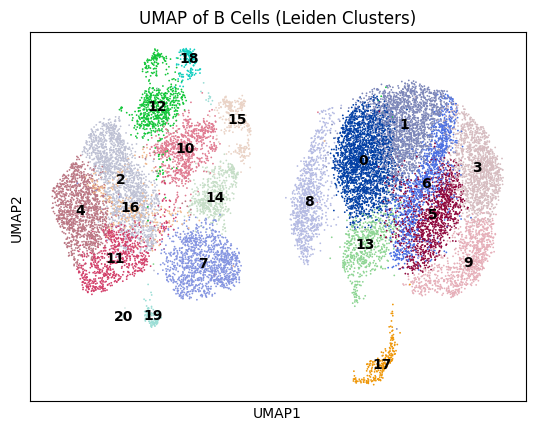

/var/folders/zg/0k9dpp614nxbvdbh46x_9d_h0000gn/T/ipykernel_1841/844725995.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = adata_b.obs.groupby(["leiden", "marker_type"]).size().reset_index(name="count")


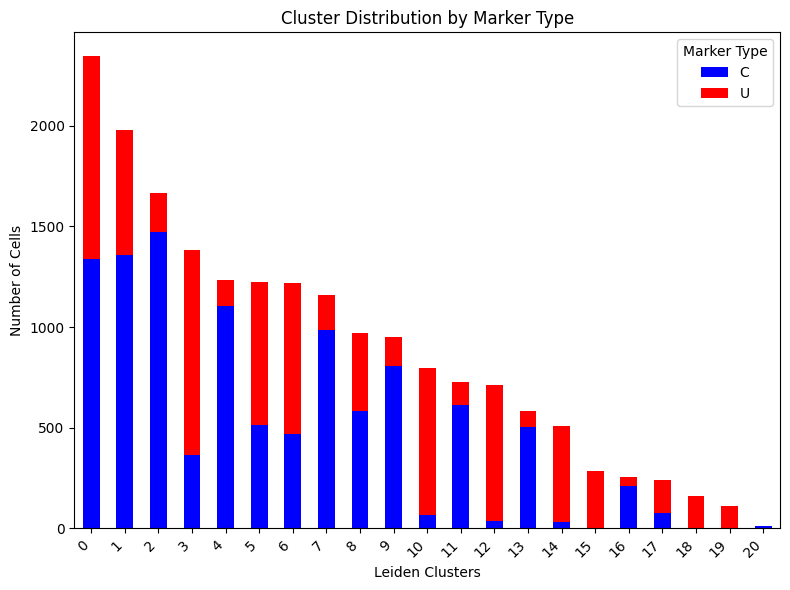

In [5]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Load the annotated single-cell data
adata = sc.read_h5ad("annotated_single_cell_data.h5ad")

# Step 2: Extract B cell data
adata_b = adata[adata.obs["cell_type"] == "B_cells"].copy()

# Step 3: Perform PCA
sc.tl.pca(adata_b, n_comps=50)

# Step 4: Construct a neighbor graph
sc.pp.neighbors(adata_b, n_neighbors=15, n_pcs=20)

# Step 5: Perform Leiden clustering
sc.tl.leiden(adata_b, resolution=1.0)
# Cluster labels are now stored in adata_b.obs["leiden"]

# Step 6: Compute UMAP
sc.tl.umap(adata_b)

# Step 7: Generate UMAP plot colored by Leiden labels
sc.pl.umap(adata_b, color="leiden", title="UMAP of B Cells (Leiden Clusters)", legend_loc="on data")

# Step 8: Summarize distribution of cells across clusters and marker types
# Ensure that marker types are stored in adata_b.obs["marker_type"]
# Create a grouped dataframe
summary = adata_b.obs.groupby(["leiden", "marker_type"]).size().reset_index(name="count")

# Reshape the data into a pivot table
pivot_table = summary.pivot(index="leiden", columns="marker_type", values="count").fillna(0)

# Step 9: Generate a stacked bar chart
# Assign colors to marker types
marker_colors = {"U": "red", "C": "blue"}  

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the stacked bar chart
pivot_table.plot(
    kind="bar",
    stacked=True,
    color=[marker_colors.get(marker, "gray") for marker in pivot_table.columns],
    ax=ax
)

# Customize the plot
ax.set_title("Cluster Distribution by Marker Type")
ax.set_xlabel("Leiden Clusters")
ax.set_ylabel("Number of Cells")
ax.legend(title="Marker Type")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment="right")

# Optimize layout for clarity
plt.tight_layout()

# Show the plot
plt.show()